# Decoder
currently GPT2 lightweight model

variants:
autoreg x dst -

wpe as intensity order - default

no wpe - TODO (easy, add positions ids all same, only use different DS, dataloader)

gas2vec embed - easy if fixed - direct embeddings as input - only use different DS, daloader, harder if further trained



## Settings

In [1]:
base = "data"
dataset = "nist"
kind = "de_novo"


wv_path = f"gas2vec/{kind}.model"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"


%load_ext autoreload
%autoreload 2

In [ ]:
from gensim.models import Word2Vec

w2v = Word2Vec.load(wv_path)
vocab = {e:i for i, e in enumerate(w2v.wv.index2entity)}
#vocab["unknown"] = -1


## Data loading

In [ ]:
from matchms.importing import load_from_msp
from spec2vec import SpectrumDocument
from data_utils import spectrum_processing
from data_utils import IntegerMzCoder, TextMzCoder, TopKDS, GenDS, HuggDS
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch

In [4]:
def load_process_documents(path, max_peaks=None):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None, max_peaks=max_peaks) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]
    return documents

documents_train = load_process_documents(data_train_path)
documents_val = load_process_documents(data_val_path)
documents_test = load_process_documents(data_test_path)

In [5]:
datasets = {
    "hugg_train": HuggDS(documents_train, vocab, max_len=256, add_intensity=False,quadratic=False), 
    "hugg_val": HuggDS(documents_val, vocab, max_len=256), 
    "hugg_test": HuggDS(documents_test, vocab, max_len=256), 
}

dataloaders = {
    "train": DataLoader(datasets["hugg_train"], batch_size=64, shuffle=True, num_workers=8),
    "val": DataLoader(datasets["hugg_val"], batch_size=256, shuffle=True, num_workers=8),
    "test": None
}

In [6]:
#datasets["hugg_val"][3]["attention_mask"].dtype

## Models definition

In [24]:
import numpy as np
import torch
from transformers import GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config(n_positions=256, vocab_size=len(vocab)+1, \
                            bos_token_id=len(vocab), eos_token_id=len(vocab))#\
#                               pad_token_id=len(vocab))


configuration = GPT2Config(n_positions=256, vocab_size=len(vocab)+1, \
                            bos_token_id=len(vocab), eos_token_id=len(vocab), n_ctx=256)#, n_head=6, n_layer=6)
#\
#                               pad_token_id=len(vocab))


In [25]:
# Initializing a model from the configuration
gpt2 = GPT2LMHeadModel(configuration)

# Accessing the model configuration
configuration = gpt2.config

configuration

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 998,
  "embd_pdrop": 0.1,
  "eos_token_id": 998,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 6,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 256,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.4.2",
  "use_cache": true,
  "vocab_size": 999
}

In [26]:
gpt2.w2v = w2v

In [27]:
# my dataset returns dict of padded tensors to len of context and attention mask 
# TO SOLVE - should tokenizer add EOS? - prolly not

# my dataloader natively batches it

# my trainer simply moves dict vals to device and calls model(dict)

## Training


In [28]:
import tqdm

class Learner():
    def __init__(self, train_loader, val_loader, model, optimizer, loss_fn, \
                 lr_scheduler, device, style, model_name="model"):
        self.train_loader= train_loader
        self.val_loader = val_loader
        self.model = model 
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.model_name=model_name
        self.train_losses = []
        self.val_losses = []
        self.style = style
        
        
    def evaluate(self, loader):
        eval_loss = 0
        self.model.eval()
        self.model.to(self.device)
        for b, batch in enumerate(loader):
            with torch.no_grad():
                batch = {k: v.to(device) for k, v in batch.items()}
                
                if self.style == "simple":
                    outputs = self.model(**batch, labels=batch["input_ids"])
                    loss = outputs.loss

                
#                 if self.style == "given_k":
#                     log_pred,_ = self.model(X, return_sequence=False)
#                     loss = self.loss_fn(log_pred, y)
#                 else:
#                     log_pred, _ = self.model(X)
#                     loss = self.loss_fn(log_pred.reshape(-1, log_pred.shape[2]), y.ravel())
                
                eval_loss += loss.item()
            
        eval_loss /= len(loader)
        
        return eval_loss
    
    def train(self,n_epochs, early_stopping=True, patience=3, verbose=False):
        self.model.to(self.device)

        if early_stopping:
            min_val_loss = np.inf
            no_improve = 0
        
        
        e_bar = tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True, desc="Epoch: ")
        for e in e_bar:
            # train
            train_loss = 0
            self.model.train()
            for b, batch in enumerate(self.train_loader):
                
                batch = {k: v.to(device) for k, v in batch.items()}
                
                # zero the parameter gradients
                self.optimizer.zero_grad()
                if self.style == "simple":
                    outputs = self.model(**batch, labels=batch["input_ids"])
                    loss = outputs.loss
                loss.backward()

                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                
#                 if self.style == "given_k":
#                     log_pred,_ = self.model(X, return_sequence=False)
#                     loss = self.loss_fn(log_pred, y)
#                 else:
#                     log_pred, _ = self.model(X)
#                     loss = self.loss_fn(log_pred.reshape(-1, log_pred.shape[2]), y.ravel())
              
#                 loss.backward()
#                 self.optimizer.step()
                if verbose and b % (len(self.train_loader)//100) == 0:
                    print(f"Done: {b}/{len(self.train_loader)}")
            
            # evaluate (train, validation)
            train_loss = self.evaluate(self.train_loader)
            val_loss = self.evaluate(self.val_loader)

            # early stopping
            if early_stopping:
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    torch.save(self.model, f"models/{kind}/{self.model_name}")
                    no_improve = 0
                else:
                    no_improve += 1
            if no_improve > patience:
                print("Early stopped")
                self.model = torch.load(f"models/{kind}/{self.model_name}")
                break
            
            #print(f"After {e+1} epochs: ")
            e_bar.set_postfix({'Train loss': f"{train_loss:.3}",'Val loss': f"{val_loss:.3}" })
            #print(f"Train loss: {train_loss:.3}")
            #print(f"Val loss: {val_loss:.3}\n")
                
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            np.save(f"losses/{kind}/{self.model_name}_train_loss.npy", self.train_losses)
            np.save(f"losses/{kind}/{self.model_name}_val_loss.npy", self.val_losses)

        np.save(f"losses/{kind}/{self.model_name}_train_loss.npy", self.train_losses)
        np.save(f"losses/{kind}/{self.model_name}_val_loss.npy", self.val_losses)
        
        return self.train_losses, self.val_losses
    

In [29]:
# discver whether to use GPU or not
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)


cuda


In [30]:
gpt2 = gpt2.to(device)

In [31]:
from transformers import AdamW
from transformers import get_scheduler


optimizer = AdamW(gpt2.parameters(), lr=5e-5)


num_epochs = 30
num_training_steps = num_epochs * len(dataloaders["train"])
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [32]:
pytorch_total_params = sum(p.numel() for p in gpt2.parameters() if p.requires_grad)

print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 43M


In [33]:
gpt2_learner = Learner(dataloaders["train"], dataloaders["val"], gpt2, optimizer, None, \
                      None, device, style="simple", model_name="gpt2_lr5e-5nshead6l6")

In [34]:
train_losses, val_losses = gpt2_learner.train(num_epochs, early_stopping=True, patience=3, verbose=False)

Epoch:  83%|████████▎ | 25/30 [4:40:19<55:56, 671.40s/it, Train loss=1.38, Val loss=1.6]  ]

Early stopped


Epoch:  83%|████████▎ | 25/30 [4:51:32<58:18, 699.69s/it, Train loss=1.38, Val loss=1.6]


In [35]:
print(train_losses)

[1.8170877056159789, 1.7413241041970924, 1.6971370966420243, 1.6622958402251329, 1.6354085886583498, 1.6118461070224783, 1.591088471339445, 1.572094198753795, 1.555754321388199, 1.5397701674915019, 1.5251717367801336, 1.5114934425446198, 1.4986342015441318, 1.4861670264744915, 1.4750080958394323, 1.46299313695586, 1.4531149847757623, 1.4425776113086306, 1.4313258613277844, 1.421409831895793, 1.4128822841392108, 1.4027293707655342, 1.3947282107946783, 1.3862659969992823, 1.377428224048121]


In [36]:
print(val_losses)

[1.8218134945089166, 1.7520048770037564, 1.7157119837674228, 1.6883245251395487, 1.6700624238361013, 1.6546073328364979, 1.64297818812457, 1.6326522480357777, 1.6254542058164423, 1.6192916230721908, 1.6133808580311861, 1.6101495721123436, 1.6050608320669695, 1.6017373811114919, 1.6005451733415776, 1.5985915498300032, 1.5977176612073725, 1.5958125092766502, 1.5947259816256436, 1.5945589954202826, 1.5954475706273858, 1.5942054477604952, 1.5962092442946, 1.5972664659673517, 1.5961904124780135]


## Prediction

In [47]:
import torch.nn.functional as F


class PredictorDstGPT2():
    def __init__(self, model, coder_class, max_mz=None, add_intens=False, quadratic=False):
        self.model = model
        self.coder = coder_class(model.w2v, max_mz)
        self.add_intens= add_intens
        self.quadratic= quadratic
    @classmethod
    def from_file(cls, file, coder_cls, max_mz=None, device="cpu", add_intens=False, quadratic=False):
        model = torch.load(file,  map_location=torch.device(device)) 
        return cls(model, coder_class=coder_cls, max_mz=max_mz, add_intens=add_intens, quadratic=quadratic)
    
    
    def __call__(self, X_ds, device="cpu"):
        self.model= self.model.to(device)
        X_ds = X_ds.to(device)
        
        with torch.no_grad():
            # return distribution for next peak 
            return F.softmax(self.model(**{"input_ids":X_ds}).logits[:, len(X_ds[0])-1],  dim=-1)
    
    def predict_l_next(self, X_dict_batch, l, filtered=True, device="cpu"):
        """
        receives indices and intens and predicts l next peaks
        if filtered: returns only non-repetitive indices that are not given as input
        """
        with torch.no_grad():
            logits = self.model(**X_dict_batch).logits[:, len(X_dict_batch["input_ids"][0])-1]
        
        if filtered:
            args_batch = torch.argsort(logits, dim=-1, descending=True).int().cpu()
            res = torch.empty((len(X_dict_batch["input_ids"]), l), dtype=torch.int)
            for i in range(len(args_batch)):
                given = set(X_dict_batch["input_ids"][i])
                solved = 0
                for j in range(len(args_batch[0])):
                    if args_batch[i][j] not in given:
                        res[i][solved] = args_batch[i][j]
                        solved +=1
                    if solved == l:
                        break
                
            return res.numpy()
        
        return torch.argsort(logits, dim=-1, descending=True)[:, :l].cpu().numpy()
        

    def predict_l_all(self, hugg_ds, up_to_k, l, batch_size=64, filtered=True, verbose=False, device="cpu"):
        # to add intensity when necessary
        hugg_ds.add_intensity = self.add_intens
        hugg_ds.quadratic = self.quadratic
        self.model= self.model.to(device)
        
        #loader = DataLoader(hugg_ds, batch_size=batch_size, shuffle=True, num_workers=8)
        def loader_gen(ds, batch_size):
            keys= ds[0].keys()
            for i in range((len(ds)//batch_size)):
                n_sam = batch_size #if i*batch_size < len(ds) else len(ds) % batch_size
                batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
                for j in range(n_sam):
                    for key in keys:
                        batch[key][j] = ds[i*batch_size+j][key]
                yield batch
            
            n_sam = len(ds)% batch_size
            
            batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
            for j in range(n_sam):
                for key in keys:
                    batch[key][j] = ds[(i+1)*batch_size+j][key]
            yield batch
        
        loader = loader_gen(hugg_ds, batch_size)
        len_loader = len(hugg_ds)//batch_size + 1

        X_intens = [np.sort(doc.peaks.intensities)[::-1][:min(self.model.config.n_positions, len(doc.peaks.intensities))-1] for doc in hugg_ds.ref_docs]
        
        l_pred_indices_per_k = np.ones(shape=(up_to_k, len(hugg_ds), l)) * (-1)
        y_indices = []
        for b, X_dict_batch_ in enumerate(loader):
                
#             indices, intens = X_ds[:,0].numpy().astype(int), X_ds[:,1].numpy()
            y_indices += [arr[(X_dict_batch_["attention_mask"][u]==1).numpy()][1:] for u, arr in enumerate((X_dict_batch_["input_ids"].numpy().astype(int)))]            

            
    #             X_intens.append(intens)
            for j in range(1, up_to_k+1):
                # we skip evaluation for too short spectra
#                 if j > len(indices):
#                     continue
               # print(j)
                X_dict_batch = {"input_ids": X_dict_batch_["input_ids"][:, :j].clone()}
                
                if "position_ids" in X_dict_batch_.keys():
                    X_dict_batch["position_ids"] = X_dict_batch_["position_ids"][:, :j].clone()
                
                
                # drop too short spectra
                # get mask - for each sample in batch either True (long enough) or False (too short) 
                len_mask = X_dict_batch_["attention_mask"][:, j-1] == 1
                
                X_dict_batch["input_ids"] = X_dict_batch["input_ids"][len_mask]
                if "position_ids" in X_dict_batch_.keys():
                    X_dict_batch["position_ids"] = X_dict_batch["position_ids"][len_mask]
              
                # no samples in batch left after cutting 
                if len_mask.sum() == 0:
                    continue
                X_dict_batch = {k: v.to(device) for k, v in X_dict_batch.items()}

                l_next = self.predict_l_next(X_dict_batch, l, filtered, device=device)
                
                l_pred_indices_per_k[j-1,b*batch_size: (b+1)*(batch_size)][len_mask] = l_next
            
            if verbose and b % 1 == 0:
                print(f"Done: {b}/{len_loader}")
        return l_pred_indices_per_k, y_indices, X_intens 


class PredictorAutoGPT2():
    def __init__(self, model, coder_class, max_mz=None):
        self.model = model
        self.coder = coder_class(model.w2v, max_mz)
#         self.add_intensity = True
    
#     def predict(self, indices, intensities):
#         return self.model([indices], [intensities])
    
#     def predict_ith_from_batch(self, docs, i):
#         return self.model([self.coder.encode(docs[i].words)], [np.array(docs[i].weights)])
        
#     def predict_batch(self, docs):
#         res = np.empty((len(docs), self.coder.get_embedding_dimension()))
#         encoded = []
#         ints = []
#         for doc in docs:
#             enc, kept = self.coder.encode(doc.words)
#             encoded.append(enc)
#             ints.append(np.array(doc.weights)[kept])
            
#         res = self.model(encoded, ints)
#         return res


    @classmethod
    def from_file(cls, file, coder_cls, max_mz=None, device="cpu"):
        model = torch.load(file,  map_location=torch.device(device)) 
        return cls(model, coder_class=coder_cls, max_mz=max_mz)
    
    
    def __call__(self, X_ds, device="cpu"):
        self.model= self.model.to(device)
        X_ds = X_ds.to(device)
        
        with torch.no_grad():
            # return distribution for next peak 
            return F.softmax(self.model(**{"input_ids":X_ds}).logits[:, len(X_ds[0])-1], dim=-1)
    
    def predict_l_next(self, X_dict_batch, l, filtered=True, device="cpu"):
        """
        receives indices and intens and predicts l next peaks
        if filtered: returns only non-repetitive indices that are not given as input
        """
        
        k = X_dict_batch["input_ids"].shape[1]

        if filtered:
            return self.model.generate(
                X_dict_batch["input_ids"], 
                max_length=k+l, 
                #num_beams=5, 
                no_repeat_ngram_size=1, 
                #encoder_no_repeat_ngram_size=1,
                #early_stopping=True, 
                #bad_words_ids = X_dict_batch["input_ids"].tolist(),
                pad_token_id=len(self.coder.vocab)
            ).cpu().numpy()[:, k:]

#             res = torch.empty(len(X_dict_batch["input_ids"]), l, dtype=torch.int) 
#             for i in range(len(beam_output)):
#                 uniq_row = torch.unique(beam_output[i])
#                 assert len(uniq_row) >= l 
#                 res[i, :] = uniq_row[:l]
#             return res
            
        
        return self.model.generate(
                X_dict_batch["input_ids"], 
                max_length=k+l, 
                #num_beams=5, 
                #early_stopping=True, 
                pad_token_id=len(self.coder.vocab)
        ).cpu().numpy()[:, k:]
        
#       
    def predict_l_all(self, hugg_ds, up_to_k, l, batch_size=64, filtered=True, verbose=False, device="cpu"):
        # to add intensity when necessary
        hugg_ds.add_intensity = False
        
        
        self.model= self.model.to(device)
        
        #loader = DataLoader(hugg_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        def loader_gen(ds, batch_size):
            keys= ds[0].keys()
            for i in range((len(ds)//batch_size)):
                n_sam = batch_size #if i*batch_size < len(ds) else len(ds) % batch_size
                batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
                for j in range(n_sam):
                    for key in keys:
                        batch[key][j] = ds[i*batch_size+j][key]
                yield batch
            
            n_sam = len(ds)% batch_size
            
            batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
            for j in range(n_sam):
                for key in keys:
                    batch[key][j] = ds[(i+1)*batch_size+j][key]
            yield batch
            
        loader = loader_gen(hugg_ds, batch_size)
        len_loader = len(hugg_ds)//batch_size + 1
        X_intens = [np.sort(doc.peaks.intensities)[::-1][:min(self.model.config.n_positions, len(doc.peaks.intensities))-1] for doc in hugg_ds.ref_docs]

        
        l_pred_indices_per_k = np.ones(shape=(up_to_k, len(hugg_ds), l)) * (-1)
        y_indices = []

        for b, X_dict_batch_ in enumerate(loader):
                
#             indices, intens = X_ds[:,0].numpy().astype(int), X_ds[:,1].numpy()
            y_indices += [arr[(X_dict_batch_["attention_mask"][u]==1).numpy()][1:] for u, arr in enumerate((X_dict_batch_["input_ids"].numpy().astype(int)))]            

#             X_intens.append(intens)
            for j in range(1, up_to_k+1):
                # we skip evaluation for too short spectra
#                 if j > len(indices):
#                     continue
               # print(j)
                X_dict_batch = {"input_ids": X_dict_batch_["input_ids"][:, :j].clone()}#{k: v.detach().clone() for k, v in X_dict_batch_.items()}
                
               # drop too short spectra
                # get mask - for each sample in batch either True (long enough) or False (too short) 
                len_mask = X_dict_batch_["attention_mask"][:, j-1] == 1
                
                X_dict_batch["input_ids"] = X_dict_batch["input_ids"][len_mask]

                
                # no samples in batch left after cutting 
                if len_mask.sum() == 0:
                    continue
                X_dict_batch = {k: v.to(device) for k, v in X_dict_batch.items()}

                l_next = self.predict_l_next(X_dict_batch, l, filtered, device=device)
                
                l_pred_indices_per_k[j-1,b*batch_size: (b+1)*(batch_size)][len_mask] = l_next
            
            if verbose and b % 1 == 0:
                print(f"Done: {b}/{len_loader}")
        return l_pred_indices_per_k, y_indices, X_intens 

## Visualisation

In [48]:
from visual_utils import plot_spectrum_predictions

predictor = PredictorDstGPT2.from_file(f"models/{kind}/gpt2_lr5e-5ns", TextMzCoder, max_mz=None)
predictor.model.cpu()
i = 100
k = 4

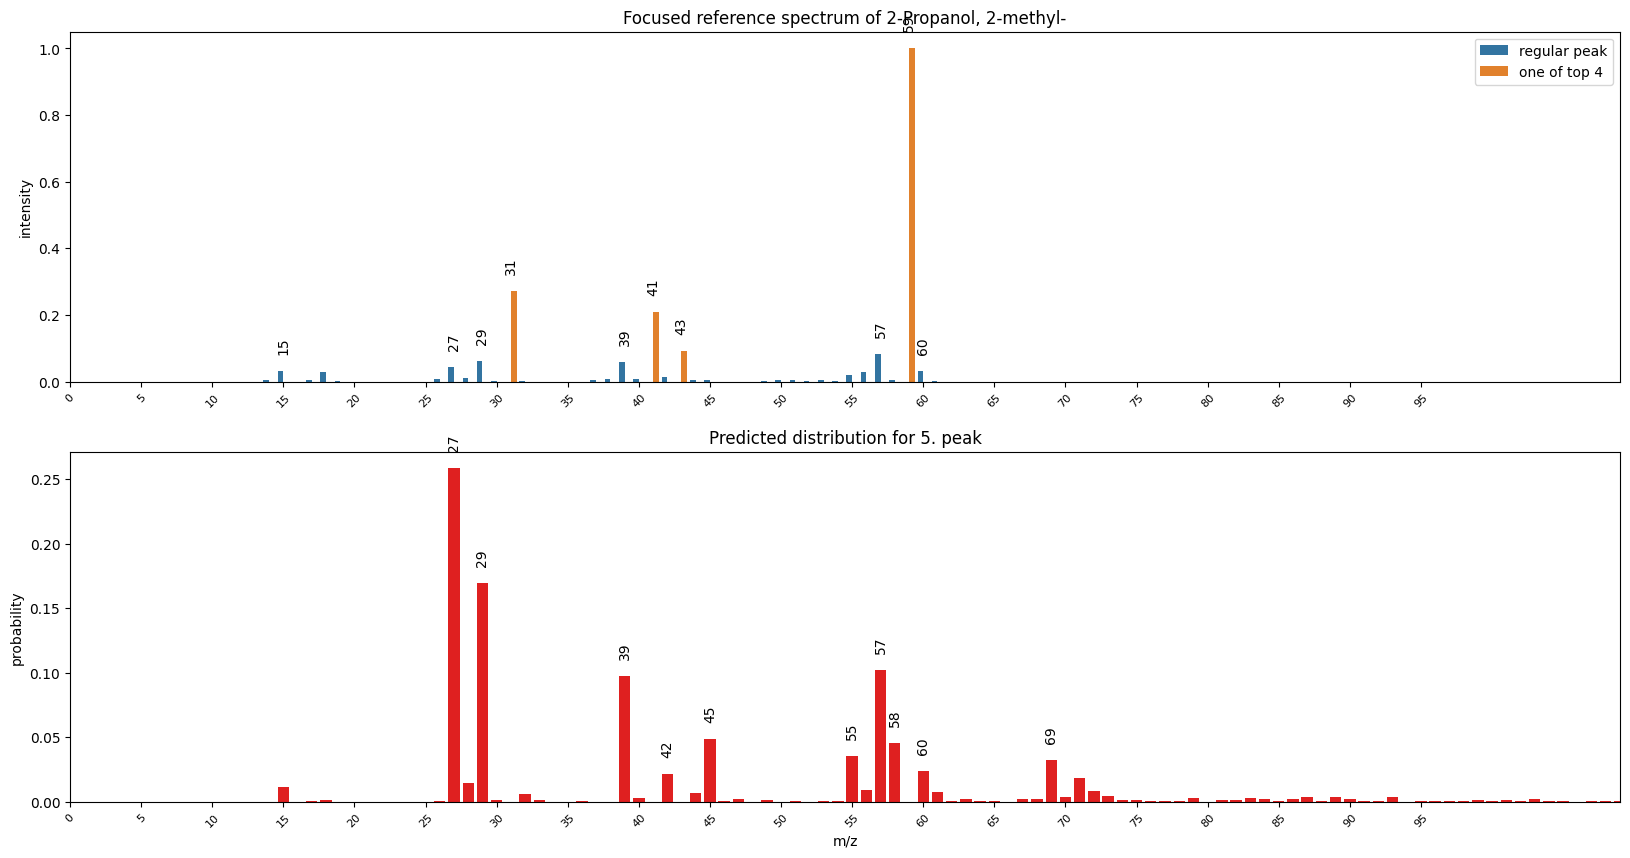

In [49]:
plot_ds = TopKDS(documents_val, vocab, k, onehot=False, add_intensity=False)
prob = predictor(plot_ds[i][0].reshape(1, *plot_ds[i][0].shape))[0,:-1].cpu().numpy()
plot_spectrum_predictions(plot_ds.ref_docs[i], k, prob, predictor.coder, plot_full=False)


## Model Selection
done on the val set

In [50]:
P_FOLDER = f"predictions/{kind}"
up_to_k = 30
l = 20

In [51]:
import os
from metrics import metrics_klj, metrics_intlj

# predictors = {#"gpt2": PredictorAutoGPT2(gpt2.cpu(), TextMzCoder, max_mz=None), 
#              "gpt2_test": PredictorAutoGPT2.from_file(f"models/{kind}/gpt2_lr5e-5_ns", TextMzCoder, max_mz=None, device=device)}
# P_FOLDER = f"predictions/{kind}"
# up_to_k = 5
# l = 1

predictors = { 
            "gpt2_dst": PredictorDstGPT2.from_file(f"models/{kind}/gpt2_lr5e-5ns", TextMzCoder, max_mz=None, device=device),  
            "gpt2_auto": PredictorAutoGPT2.from_file(f"models/{kind}/gpt2_lr5e-5ns", TextMzCoder, max_mz=None, device=device),
            "gpt2_lin_intens_dst": PredictorDstGPT2.from_file(f"models/{kind}/gpt2_lr5e-5ns_intens", TextMzCoder, max_mz=None, device=device, add_intens=True),
            "gpt2_quad_intens_dst": PredictorDstGPT2.from_file(f"models/{kind}/gpt2_lr5e-5ns_intens_quad", TextMzCoder, max_mz=None, device=device, add_intens=True, quadratic=True),    
            "gpt2_only30_dst": PredictorDstGPT2.from_file(f"models/{kind}/gpt2_lr5e-5ns_only30peaks", TextMzCoder, max_mz=None, device=device),  
            "gpt2_only30_auto": PredictorAutoGPT2.from_file(f"models/{kind}/gpt2_lr5e-5ns_only30peaks", TextMzCoder, max_mz=None, device=device),
            "gpt2_embd300_dst": PredictorDstGPT2.from_file(f"models/{kind}/gpt2_lr5e-5ns300embd", TextMzCoder, max_mz=None, device=device),  
            "gpt2_embd300_auto": PredictorAutoGPT2.from_file(f"models/{kind}/gpt2_lr5e-5ns300embd", TextMzCoder, max_mz=None, device=device),
            "gpt2_h6l6_dst": PredictorDstGPT2.from_file(f"models/{kind}/gpt2_lr5e-5nshead6l6", TextMzCoder, max_mz=None, device=device),  
            "gpt2_h6l6_auto": PredictorAutoGPT2.from_file(f"models/{kind}/gpt2_lr5e-5nshead6l6", TextMzCoder, max_mz=None, device=device),

                        
}


In [52]:
P_FOLDER

'predictions/de_novo'

In [53]:
from model_evaluation import calc_predictions, load_predictions, model_selection
from visual_utils import plot_scores

In [54]:
%%time
calc_predictions(up_to_k, l, predictors, datasets, "hugg_val", P_FOLDER, batch_size=512, device=device, verbose=False)

gpt2_dst


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


gpt2_auto
gpt2_lin_intens_dst
gpt2_quad_intens_dst
gpt2_only30_dst
gpt2_only30_auto
gpt2_embd300_dst
gpt2_embd300_auto
gpt2_h6l6_dst
gpt2_h6l6_auto
CPU times: user 1h 59min 51s, sys: 8min, total: 2h 7min 52s
Wall time: 2h 8min 20s


gpt2_embd300_dst
Possible k up to 30, predict up to 20 peaks
Selected up to k=20, l=4, j=6
[28034 28034 28034 28034 27994 27960 27908 27857 27773 27699 27611 27522
 27437 27335 27244 27124 27001 26900 26791 26695]
[28034 28034 28034 28034 27994 27960 27908 27857 27773 27699 27611 27522
 27437 27335 27244 27124 27001 26900 26791 26695]
Selected up to k=20, l=None, to_rel_inten=0.2
problem - spectrum with unknown peak skipped
[25995 27731 27989 28015 28032 28030 28033 28029 28031 27989 27957 27905
 27853 27769 27694 27609 27517 27435 27333 27241]
[25995 27731 27989 28015 28032 28030 28033 28029 28031 27989 27957 27905
 27853 27769 27694 27609 27517 27435 27333 27241]
gpt2_dst
Possible k up to 30, predict up to 20 peaks
Selected up to k=20, l=4, j=6
problem - spectrum with unknown peak skipped
[25995 27731 27989 28015 28032 28030 28033 28029 28031 27989 27957 27905
 27853 27769 27694 27609 27517 27435 27333 27241]
[25995 27731 27989 28015 28032 28030 28033 28029 28031 27989 27957 27905
 2

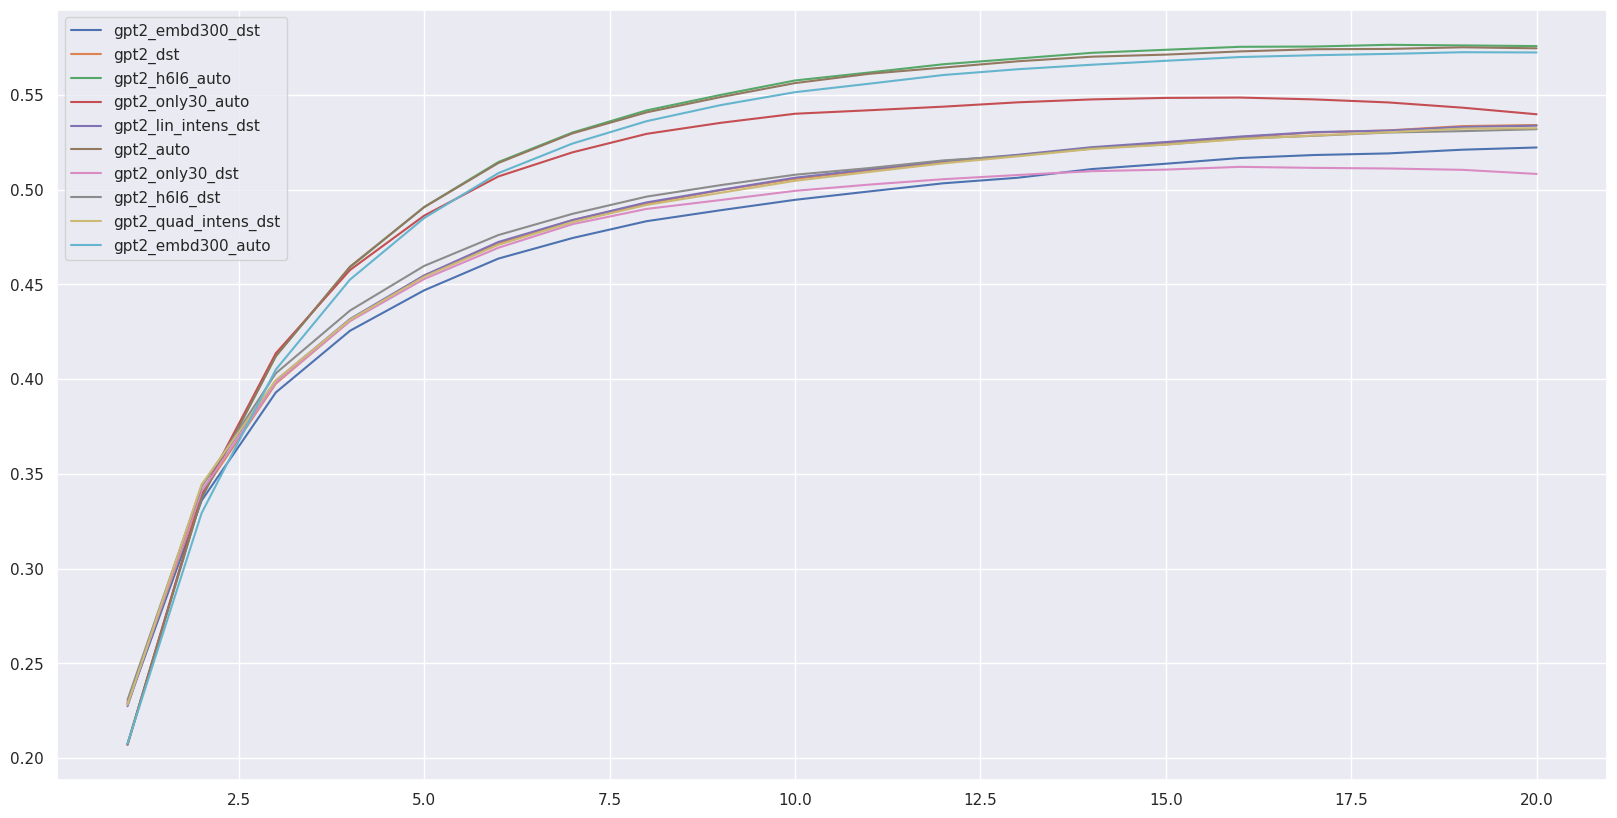

In [56]:
best_p_name, scores = model_selection(P_FOLDER, "hugg_val", predictors=predictors, up_to_k=20, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)
plot_scores(scores, metrics="mpi")

In [57]:
best_p_name

'gpt2_h6l6_auto'

In [ ]:
best_p_name

## Visualisation of the best predictor

In [ ]:
prob = predictors[best_p_name](plot_ds[i][0].reshape(1, *plot_ds[i][0].shape))[0,:-1].cpu().numpy()
plot_spectrum_predictions(plot_ds.ref_docs[i], k, prob, predictors[best_p_name].coder)

## Detailed evaluation of the best predictor 
done on the test set

In [ ]:
%%time
up_to_k = 50
l = l
calc_predictions(up_to_k, l, {best_p_name: predictors[best_p_name]}, "hugg_test", P_FOLDER)

In [ ]:
l_pred_indices_per_k_best, y_indices, X_intens = load_predictions(best_p_name, "hugg_test", P_FOLDER)
l_pred_indices_per_k_base, y_indices_base, X_intens_base = load_predictions("base_1", "spec_test", P_FOLDER)

In [ ]:
from metrics import accuracy_at_k
from visual_utils import plot_stats

def get_to_len(xs, len_):
    return [xs[i] if i<len(xs) else 0 for i in range(len_)]

accs_at_k = accuracy_at_k(l_pred_indices_per_k_best, y_indices, up_to_k=None)
accs_at_k_base = get_to_len(accuracy_at_k(l_pred_indices_per_k_base, y_indices_base, up_to_k=None), len(accs_at_k))



plot_stats(accs_at_k, baseline1D=accs_at_k_base, title="Accuracy@k", color="red", ylabel='accuracy', xlabel='k')

In [ ]:
from metrics import accuracy_at_int

accs_at_int = accuracy_at_int(l_pred_indices_per_k_best, y_indices, X_intens)
accs_at_int_base = get_to_len(accuracy_at_int(l_pred_indices_per_k_base, y_indices_base, X_intens_base), len(accs_at_int))

In [ ]:
plot_stats(accs_at_int, baseline1D=accs_at_int_base, title="Accuracy@int", color="red", decreasing=True,  ylabel='accuracy', xlabel='intensity level', x_factor=.01)

In [ ]:
sum(l_pred_indices_per_k_base[30][:,0] != -1)

In [ ]:
to_rel_inten=.2
j=6
l=4
up_to_k=50

In [ ]:
mean_prec, mean_jac, mean_prec_int, mean_jac_int = calc_mean_lj_metrics(l_pred_indices_per_k_best, y_indices, \
                                                                        X_intens, up_to_k=up_to_k, l=l, j=j, \
                                                                        l_rel=None, to_rel_inten=to_rel_inten)

mean_prec_base, mean_jac_base, mean_prec_int_base, mean_jac_int_base = calc_mean_lj_metrics(l_pred_indices_per_k_base, \
                                                                                            y_indices_base, X_intens_base, \
                                                                                            up_to_k=up_to_k, l=l, j=j,\
                                                                                            l_rel=None, to_rel_inten=to_rel_inten)

#mean_prec_base = get_to_len(mean_prec_base, len(mean_prec))
#mean_jac_base = get_to_len(mean_jac_base, len(mean_jac))

In [ ]:
plot_stats(mean_prec, baseline1D=mean_prec_base, title="Mean_Prec", color="green", ylabel='precision', xlabel='k')

In [ ]:
plot_stats(mean_jac, baseline1D=mean_jac_base, title="Mean_Jac", color="blue", ylabel='jaccard', xlabel='k')

In [ ]:
plot_stats(mean_prec_int, baseline1D=mean_prec_int_base, title="Mean_Prec", color="green", ylabel='precision', xlabel='k')

In [ ]:
plot_stats(mean_jac_int, baseline1D=mean_jac_int_base, title="Mean_Jac", color="blue", ylabel='jaccard', xlabel='k')

In [ ]:
assert False

In [ ]:
  batch_size = len(X_dict_batch["input_ids"])
#         k = len(X_dict_batch["input_ids"][0])
#         pred_indices = torch.ones(batch_size, l, device=device, dtype=torch.int) * (-1)
        
#         with torch.no_grad():
# #         print(X_dict_batch)
#             out = self.model(**X_dict_batch, use_cache=True)
#         pred_ind_batch = torch.argmax(out.logits, dim=-1)[:, k-1].int()
        
#         # filtering hack
#         for j, p in enumerate(pred_ind_batch):
#             if p not in pred_indices[j] and p not in X_dict_batch["input_ids"][j]:
#                 pos = (pred_indices[j]==-1).nonzero(as_tuple=False)
#                 if len(pos) == 0:
#                     continue                
#                 pred_indices[j][pos[0]] = p
        
# #        new_mask = torch.zeros_like(X_dict_batch["attention_mask"], dtype=torch.int)
# #        new_mask[:, 0] = 1
        
    
#         #print(out.past_key_values[0][0].size(-2))
    
#         # filtering hack
#         while (pred_indices == -1).any():
# #             print(pred_ind_batch)
#             new_dict_batch = {"input_ids": pred_ind_batch.reshape(-1, 1)}
# #             print(new_dict_batch)
#             with torch.no_grad():
#                 out = self.model(**new_dict_batch, use_cache=True, past_key_values=out.past_key_values)
#             pred_ind_batch = torch.argmax(out.logits, dim=-1)[:, 0].int()
            
#             # filtering hack
#             for j, p in enumerate(pred_ind_batch):
#                 if p not in pred_indices[j] and p not in X_dict_batch["input_ids"][j]:
#                     pos = (pred_indices[j]==-1).nonzero(as_tuple=False)
#                     if len(pos) == 0:
#                         continue                
#                     pred_indices[j][pos[0]] = p
#         #print(pred_indices)
#         return pred_indices.cpu().numpy()
# #         if not filtered:
# #             return pred_indices
#         # all peaks must be unique
#         #np.unique(data
        
# #         # omit the peaks that were given as input
# #         top_k_l = get_top_k_ind(pred_indices, l+len(indices))[0]
# #         indices_match = set(indices)
# #         return np.array([ind for ind in top_k_l if ind not in indices_match][:l])
    